In [1]:
import os
import time

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.utils as tvutils

# import cv2
# import PIL
# import matplotlib.pyplot as plt

from my_utils import data, models
from my_utils.utils import save_model, check_accuracy, train
from my_utils.vis import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

In [2]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:{GPU_nums - 1}" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2
There are 8 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
CUDA version: 11.3
Using cuda:7 now!


In [3]:
batch_size = 1024
fig_resize = 32
mean, std = torch.tensor(0.2036), torch.tensor(0.4027)
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((fig_resize, fig_resize)),
    transforms.Normalize(mean, std)
])
loader_kwargs = {
    'batch_size': batch_size,   # default:1
    'shuffle': True,            # default:False
    'num_workers': 4,           # default:0
    'pin_memory': True,         # default:False
    'drop_last': True,          # default:False
    'prefetch_factor': 4,       # default:2
    'persistent_workers': False # default:False
}

In [4]:
# 制作二进制数据集
Dataset_DIR = '/home/wangyh/01-Projects/03-my/Datasets/polygons_unfilled_32_2'

train_data = data.MyDataset(os.path.join(Dataset_DIR, 'train'), transform=T)
train_loader = DataLoader(train_data, **loader_kwargs)

val_data = data.MyDataset(os.path.join(Dataset_DIR, 'val'), transform=T)
val_loader = DataLoader(val_data, **loader_kwargs)

test_data = data.MyDataset(os.path.join(Dataset_DIR, 'test'), transform=T)
test_loader = DataLoader(test_data, **loader_kwargs)

In [5]:
sample_amount = 2000
sample_step = 10

small_train_data = Subset(train_data, torch.arange(0, len(train_data) - 1, sample_step))
small_train_loader = DataLoader(small_train_data, **loader_kwargs)

small_val_data = Subset(val_data, torch.arange(0, len(val_data) - 1, sample_step))
small_val_loader = DataLoader(small_val_data, **loader_kwargs)

In [6]:
# check data before training!
img, label = train_data[0]
print(len(train_data), '\t', img.shape)
imgs, labels = next(iter(train_loader))
print(len(train_loader), '\t', imgs.shape)

img, label = val_data[0]
print(len(val_data), '\t', img.shape)
imgs, labels = next(iter(val_loader))
print(len(val_loader), '\t', imgs.shape)

40000 	 torch.Size([1, 32, 32])
39 	 torch.Size([1024, 1, 32, 32])
8000 	 torch.Size([1, 32, 32])
7 	 torch.Size([1024, 1, 32, 32])


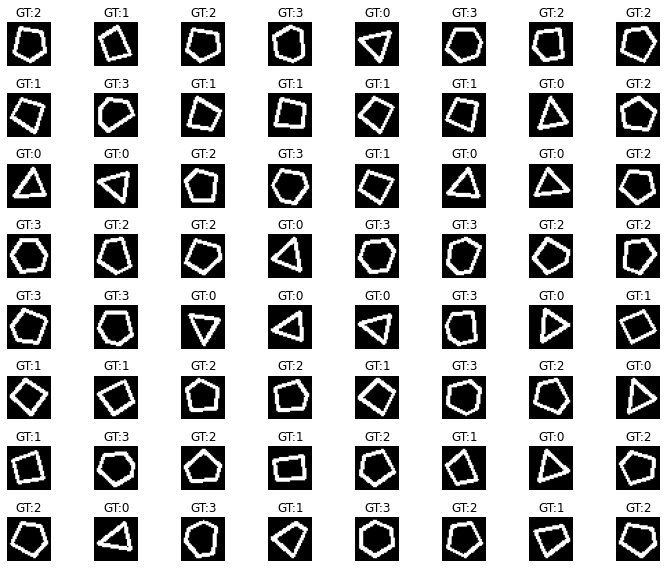

In [7]:
grid_vis(test_loader, 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


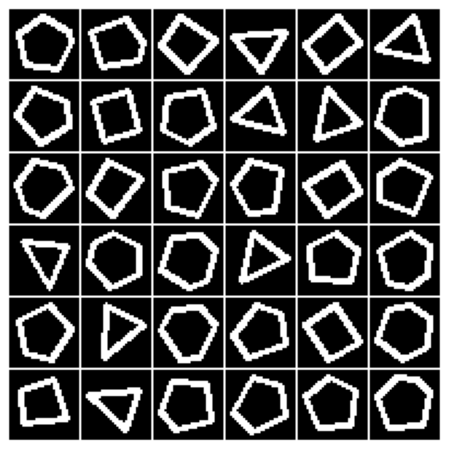

In [8]:
imgs_grid = tvutils.make_grid(imgs[:36], nrow=6, padding=1, pad_value=1)
plt.imshow(imgs_grid.permute(1,2,0))
plt.axis('off')
plt.show()

In [30]:
# model = models.simple_Conv(in_chans=1, num_classes=4, depths=(2, 2, 2) ).to(device)
model = models.my_ConvNeXt().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.05)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
loss_func = nn.CrossEntropyLoss()
print(next(model.parameters()).device)
# print(model)

cuda:7


In [ ]:
# copy the following line to prompt line!
# tensorboard --logdir runs

In [ ]:
# writer = SummaryWriter()
# writer.add_graph(model, torch.rand([1, 1, 32, 32], device=device))

In [29]:
# reset train history
batch_step = 0
writer = SummaryWriter(log_dir='./tblogs', comment="BS_1024_WD_0.05")

In [13]:
# Train and test!
check_loaders = {'train':small_train_loader,
                 'val':val_loader}

In [19]:
optimizer.param_groups[0]['lr'] = 2e-5

In [31]:
batch_step = train(model, optimizer, scheduler, loss_func, train_loader,
                   check_fn=check_accuracy,
                   check_loaders=check_loaders,
                   batch_step=batch_step, epochs=100, log_every=10, writer=writer)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f40db72ba60>
Traceback (most recent call last):
  File "/home/wangyh/anaconda3/envs/my/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/wangyh/anaconda3/envs/my/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/wangyh/anaconda3/envs/my/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f40db72ba60>
Traceback (most recent call last):
  File "/home/wangyh/anaconda3/envs/my/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    Traceback (most recent call last):
self._shutdown_workers()
  File "/home/wangyh/anaconda3/env

Epoch: 1 [0/39]	Loss: 1.4495	Val acc: 24.9%
Epoch: 1 [10/39]	Loss: 1.4610	Val acc: 24.9%
Epoch: 1 [20/39]	Loss: 1.4481	Val acc: 25.0%
Epoch: 1 [30/39]	Loss: 1.4406	Val acc: 24.9%


KeyboardInterrupt: 

In [22]:
writer.close()

In [23]:
model.eval()
test_acc = check_accuracy(model, test_loader)
print(f'Test accuracy is : {100. * test_acc:.2f}%')

Test accuracy is : 85.95%	Infer time: 0.84413743019104


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

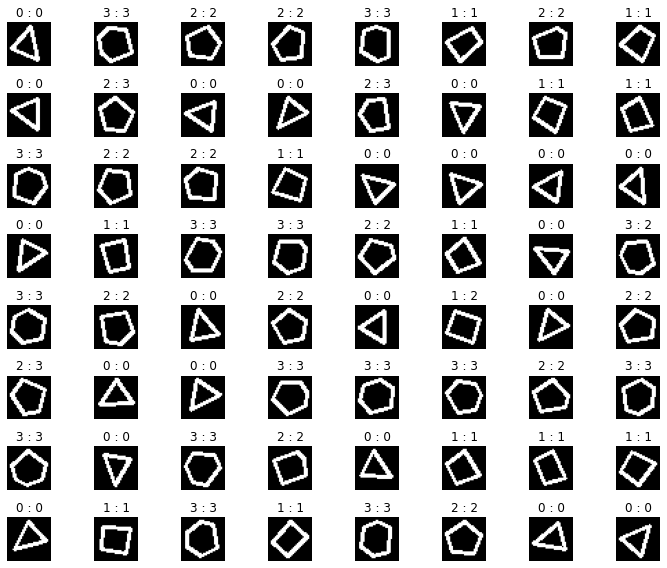

In [24]:
grid_vis(test_loader, 8, model)

In [25]:
# Save model
save_model(model, optimizer, model_type='myconvnext', acc=86)

Model parameters:
connection_layers.0.weight:	 torch.Size([4, 1])
connection_layers.0.bias:	 torch.Size([4])
connection_layers.1.weight:	 torch.Size([8, 4])
connection_layers.1.bias:	 torch.Size([8])
connection_layers.2.weight:	 torch.Size([16, 8])
connection_layers.2.bias:	 torch.Size([16])
norm_layers.0.weight:	 torch.Size([4])
norm_layers.0.bias:	 torch.Size([4])
norm_layers.0.running_mean:	 torch.Size([4])
norm_layers.0.running_var:	 torch.Size([4])
norm_layers.0.num_batches_tracked:	 torch.Size([])
norm_layers.1.weight:	 torch.Size([4])
norm_layers.1.bias:	 torch.Size([4])
norm_layers.1.running_mean:	 torch.Size([4])
norm_layers.1.running_var:	 torch.Size([4])
norm_layers.1.num_batches_tracked:	 torch.Size([])
norm_layers.2.weight:	 torch.Size([8])
norm_layers.2.bias:	 torch.Size([8])
norm_layers.2.running_mean:	 torch.Size([8])
norm_layers.2.running_var:	 torch.Size([8])
norm_layers.2.num_batches_tracked:	 torch.Size([])
stages.0.0.gamma:	 torch.Size([4])
stages.0.0.dwconv.weight

In [27]:
# reload modal paras from saved .pt file
new_model = models.my_ConvNeXt()

new_model.to(device)
new_optimizer = torch.optim.Adam(new_model.parameters(), lr=1e-5, weight_decay=0.1)

save_path = 'saved_models/97_polygen_unfilled_myconvnext_2022_01_21_19_58_50.pt'
checkpoint = torch.load(save_path)
new_model.load_state_dict(checkpoint["model_paras"])
new_optimizer.load_state_dict(checkpoint["optim_paras"])

In [28]:
new_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(new_optimizer, T_0=1, T_mult=2)

In [24]:
new_model.eval()
check_accuracy(new_model, test_loader)

Test accuracy is : 96.99%	Infer time: 6.132776260375977


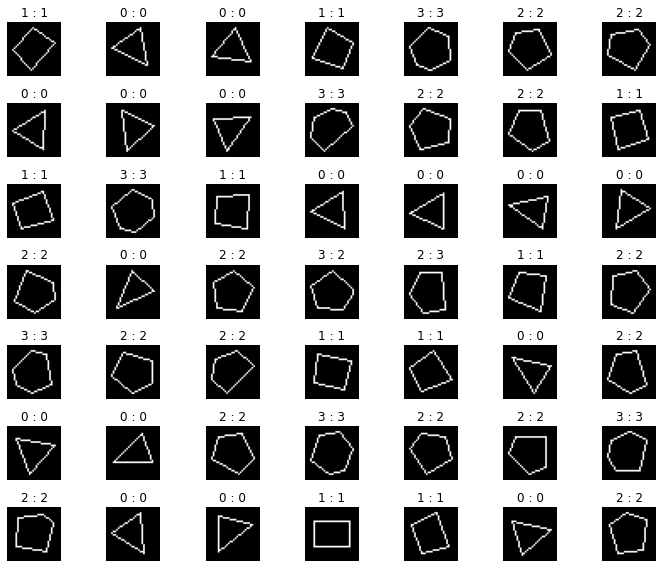

In [14]:
grid_vis(test_loader, 8, new_model)

In [28]:
vis_model = models.my_ConvNeXt_vis()
vis_model.to(device)

save_path = 'saved_models/97_polygen_unfilled_myconvnext_2022_01_21_19_58_50.pt'
checkpoint = torch.load(save_path)
new_model.load_state_dict(checkpoint["model_paras"])

<All keys matched successfully>

In [29]:
vis_model

my_ConvNeXt_vis(
  (connection_layers): ModuleList(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
  (norm_layers): ModuleList(
    (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (norm): BatchNorm2d(8, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
        (pwconv1): Linear(in_features=8, out_features=16, bias=True)
        (act): ReLU()
        (pwconv2): Linear(in_features=16, out_features=8, bias=True)
      )
    )
    (1): Sequential(
      (0): B

In [56]:
img, label = test_data[2000]
img = img[None, :, :, :].to(device, dtype=torch.float32)
# label = label.to(device, dtype=torch.int64)
vis = img.permute(0, 2, 3, 1)
scores, mid_outputs = vis_model(img)

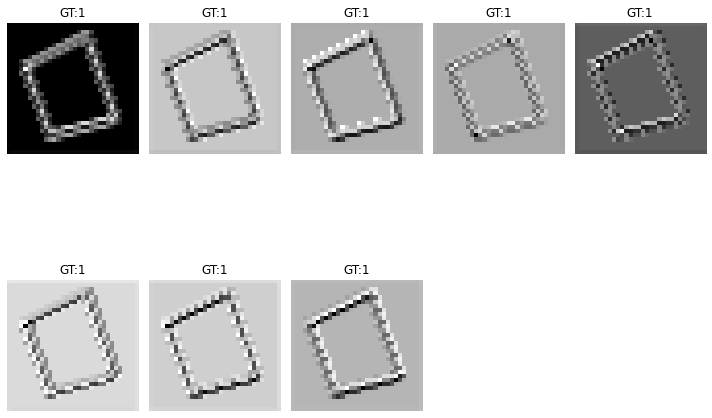

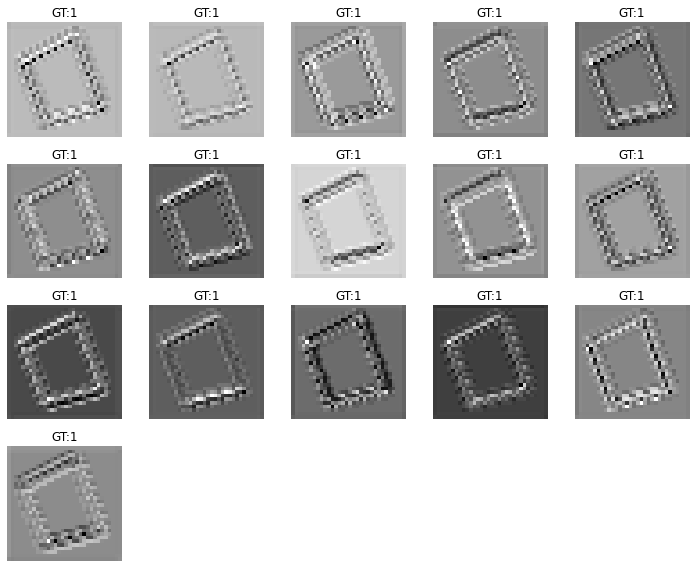

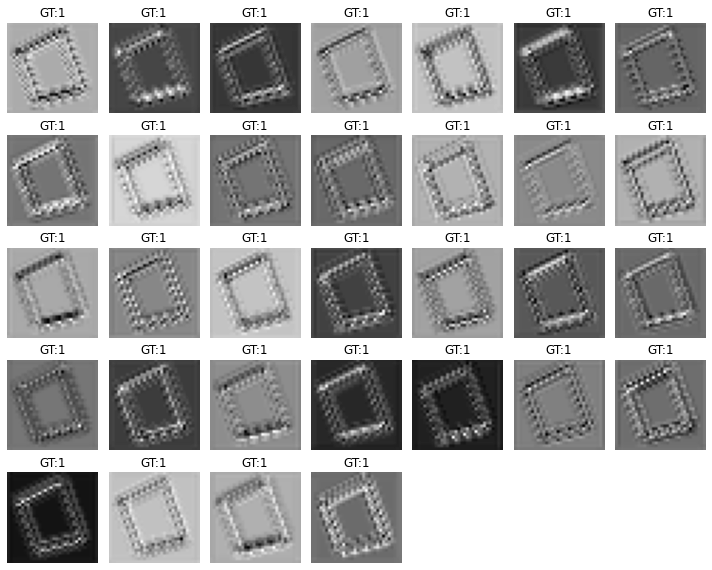

In [57]:
for act in mid_outputs:
    vis_act(act, label)